In [2]:
import pandas as pd
import numpy as np
cols = ['uid', 'iid', 'rating', 'timestamp']

In [3]:
# 全体データフレーム 評価行列Rは全体のidから作成する必要がある
df = pd.read_csv('./ml-100k/u.data', sep='\t', header=None, names=cols)

In [4]:
# 学習用
df_train = pd.read_csv('./ml-100k/ua.base', sep='\t', header=None, names=cols)

In [5]:
# テスト用
df_test = pd.read_csv('./ml-100k/ua.test',  sep='\t',header=None, names=cols)

In [6]:
df.head()

,uid,iid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
df_train.head()

,uid,iid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [8]:
df_test.head()

,uid,iid,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


In [9]:
# idが1からなのは都合が悪いので修正
df.uid = df.uid - 1
df.iid = df.iid - 1
df_train.uid = df_train.uid - 1
df_train.iid  = df_train.iid - 1
df_test.uid = df_test.uid - 1
df_test.iid  = df_test.iid - 1
# testのうち評価が高いものだけ残す。 テストで評価が低いものしか見ていないユーザには推薦しない
df_test = df_test[df_test.rating >= 4]

In [10]:
# u x i の行列を作成
user_list = df.uid.unique()  # 全体から作っているのがポイント
item_list = df.iid.unique()
R = np.zeros([len(user_list), len(item_list)])  # 初期化
print(R.shape)
R[df_train.uid, df_train.iid] = df_train.rating
print(R)

(943, 1682)
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


In [11]:
# 遅いけど、df_trainを一行ずつ見ていくことも可能
#for idx in range(len(df_train)):
#    row = df_train.iloc[idx]
#    uid, iid, rating = row.uid, row.iid, row.rating
#    R[uid, iid] = rating

In [12]:
# Rからコサイン類似度行列(各行が他の行にどれだけ似てるか=ユーザ同士の類似度）を作成
# See: https://stackoverflow.com/questions/41905029/create-cosine-similarity-matrix-numpy
d = R @ R.T  # u x uの行列
norm = (R * R).sum(axis=1, keepdims=True) ** .5
cos_sim_matrix = d / norm / norm.T  # global変数として使う

In [13]:
cos_sim_matrix

array([[1.        , 0.14675076, 0.0506765 , ..., 0.03870478, 0.1727177 ,
        0.38039608],
       [0.14675076, 1.        , 0.12580785, ..., 0.17370692, 0.17318465,
        0.08094333],
       [0.0506765 , 0.12580785, 1.        , ..., 0.02798846, 0.12481628,
        0.02969262],
       ...,
       [0.03870478, 0.17370692, 0.02798846, ..., 1.        , 0.03995129,
        0.01914385],
       [0.1727177 , 0.17318465, 0.12481628, ..., 0.03995129, 1.        ,
        0.14471056],
       [0.38039608, 0.08094333, 0.02969262, ..., 0.01914385, 0.14471056,
        1.        ]])

In [14]:
def get_similar_user(uid, n_sim_u=10):
    sim = cos_sim_matrix[uid]
    sim_users_idx = list(sim.argsort()[::-1][:n_sim_u+1])  # 似ているユーザ（自分含むn_sim_u+1個）
    # 自分が含まれていれば除去
    if uid in sim_users_idx:
        sim_users_idx.remove(uid)  
    else:
        sim_users_idx = sim_users_idx[:n_sim_u]
    # 自分と似ているユーザとその類似度を保存
    return sim_users_idx

get_similar_user(0)

[915, 863, 267, 434, 456, 91, 428, 302, 275, 681]

In [16]:
def get_recommendation_list(uid, n_sim_u=10, n_rec=10):
    # 全てのアイテムの中から、uidに良さげなものを探し、良いものを上からn_rec個推薦
    score = []  # 全てのアイテムの推薦評価値を入れていく
    sim_users = get_similar_user(uid, n_sim_u=n_sim_u)
    for item, rating in enumerate(R[uid]):
        if rating != 0:  # 評価済みのものは無視して0を入れる
            score.append(0)
            continue
        # ★似ている人の評価の平均をスコアということにするが色々やりようはある
        others_rating_ave = R[sim_users][:, item].mean() 
        score.append(others_rating_ave)
    score = np.array(score)
    rec_list = score.argsort()[::-1][:n_rec]
    return rec_list

get_recommendation_list(0)

array([317, 654, 432, 422, 402, 201, 116, 356, 473, 287])

In [17]:
# テストデータを用いて推薦のHR@K （K個推薦した際のヒットレート）を評価する 
# ちょっと時間かかる
result = {}
for k in range(50):
    hit_or_not = []
    for uid in user_list:
        watched_in_test = list(df_test[df_test.uid==uid].iid)
        if len(watched_in_test) == 0:  # テストになければ無視
            continue
        hit_flag = 0
        rec_list = get_recommendation_list(uid, n_rec=k)
        for r in rec_list:
            if r in watched_in_test:
                hit_flag = 1
                break
        hit_or_not.append(hit_flag)
    result[k] = sum(hit_or_not) / len(hit_or_not)  # （ほぼ）全ユーザに推薦した際のHR@K

In [18]:
result

{0: 0.0,
 1: 0.2890792291220557,
 2: 0.42398286937901497,
 3: 0.512847965738758,
 4: 0.5738758029978587,
 5: 0.6220556745182013,
 6: 0.6616702355460385,
 7: 0.6991434689507494,
 8: 0.7334047109207709,
 9: 0.7601713062098501,
 10: 0.7805139186295503,
 11: 0.7987152034261242,
 12: 0.815845824411135,
 13: 0.8254817987152034,
 14: 0.8319057815845824,
 15: 0.8426124197002142,
 16: 0.8533190578158458,
 17: 0.8629550321199143,
 18: 0.8715203426124197,
 19: 0.8779443254817987,
 20: 0.8822269807280514,
 21: 0.8843683083511777,
 22: 0.8886509635974305,
 23: 0.892933618843683,
 24: 0.8972162740899358,
 25: 0.9014989293361885,
 26: 0.9036402569593148,
 27: 0.9089935760171306,
 28: 0.9132762312633833,
 29: 0.917558886509636,
 30: 0.917558886509636,
 31: 0.9186295503211992,
 32: 0.9218415417558886,
 33: 0.923982869379015,
 34: 0.923982869379015,
 35: 0.9271948608137045,
 36: 0.930406852248394,
 37: 0.9336188436830836,
 38: 0.9379014989293362,
 39: 0.9389721627408993,
 40: 0.9411134903640257,
 41: 0.

In [19]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'HR@k in movielens dataset')

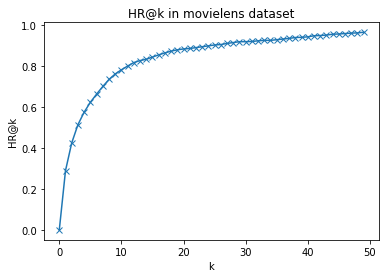

In [20]:
plt.plot(result.keys(), result.values(), marker='x')
plt.xlabel('k')
plt.ylabel('HR@k')
plt.title('HR@k in movielens dataset')